In [22]:
# first attempt at multi task learning and integration with topological quantum chemistry database
import e3nn.util
import torch
import torch.nn as nn
import torch.optim as optim
import torch_geometric
import torch_scatter

import e3nn
from e3nn import o3
#from e3nn.util.datatypes import DataPeriodicNeighbors
#from e3nn.nn._gate import GatedConvParityNetwork
#from e3nn.math._linalg import Kernel

import pymatgen as mg
import pymatgen.io
from pymatgen.core.structure import Structure
import pymatgen.analysis.magnetism.analyzer as pg
from mp_api.client import MPRester
import numpy as np
import pickle
from mendeleev import element
import matplotlib.pyplot as plt

from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

import io
import random
import math
import sys
import time, os
import datetime
from pathlib import Path
from dotenv import load_dotenv

In [23]:
load_dotenv()
load_dotenv(Path("/Users/abiralshakya/Documents/Research/Topological_Insulators_OnGithub/generative_nmti/Integrated_Magnetic_Topological/matprojectapi.env"))
api_key = os.getenv("MP_API_KEY")

In [24]:
import numpy as np
import torch
import pymatgen as pg
from pymatgen.ext.matproj import MPRester
from pymatgen.analysis.magnetism import CollinearMagneticStructureAnalyzer

order_list_mp = []
structures_list_mp = []
formula_list_mp = []
sites_list = []
id_list_mp = []
y_values_mp = []

order_encode = {"NM": 0, "AFM": 1, "FM": 2, "FiM": 2}
topo_encode = {False: 0, True: 1}

# Load data
mp_structures_dict = torch.load('/Users/abiralshakya/Documents/Research/Topological_Insulators_OnGithub/generative_nmti/Integrated_Magnetic_Topological/magnetic_order/preload_data/mp_structures_2025-04-07_12-52.pt', 
                                weights_only=False)

structures = mp_structures_dict['structures']
materials = mp_structures_dict['materials_id']
formulas = mp_structures_dict['formulas']
orders = mp_structures_dict['order']
nsites = mp_structures_dict['nsites']


In [25]:
order_list = []

for struct in structures:
    analyzer = CollinearMagneticStructureAnalyzer(struct)
    order_list.append(analyzer.ordering.name)

In [26]:
id_NM = [i for i, order in enumerate(order_list) if order == 'NM']
id_AFM = [i for i, order in enumerate(order_list) if order == 'AFM']
id_FM = [i for i, order in enumerate(order_list) if order in ['FM', 'FiM']]

# Shuffle
np.random.shuffle(id_NM)
np.random.shuffle(id_FM)
np.random.shuffle(id_AFM)

# Balance dataset (keeping AFM as reference size)
id_AFM, id_AFM_to_delete = np.split(id_AFM, [int(len(id_AFM))])
id_NM, id_NM_to_delete = np.split(id_NM, [int(1.2 * len(id_AFM))])
id_FM, id_FM_to_delete = np.split(id_FM, [int(1.2 * len(id_AFM))])

# Final index list
selected_ids = np.concatenate((id_NM, id_FM, id_AFM))
np.random.shuffle(selected_ids)

In [27]:
for idx in selected_ids:
    structure = structures[idx]
    material_id = materials[idx]
    formula = formulas[idx]
    nsite = nsites[idx]

    analyzer = CollinearMagneticStructureAnalyzer(structure)
    ordering = analyzer.ordering

    structures_list_mp.append(structure)
    id_list_mp.append(material_id)
    formula_list_mp.append(formula)
    sites_list.append(nsite)
    order_list_mp.append(ordering)


In [28]:
topo_encode = {False: 0, True: 1}
topo_labels = []

from mp_api.client import MPRester
m = MPRester(api_key=api_key)

for material_id in id_list_mp:
    try:
        result = m.materials.summary.search(material_ids=[material_id])
        if result and hasattr(result[0], "is_topological"):
            label = result[0].is_topological
            topo_labels.append(topo_encode[label])
        else:
            print(f"No topological info for {material_id}")
            topo_labels.append(topo_encode[False])
    except Exception as e:
        print(f"Error retrieving TI label for {material_id}: {e}")
        topo_labels.append(topo_encode[False])

Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<00:00, 28728.11it/s]


No topological info for mp-35


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<00:00, 21732.15it/s]


No topological info for mp-1184113


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<00:00, 26214.40it/s]


No topological info for mp-8639


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<00:00, 20460.02it/s]


No topological info for mp-1076920


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<00:00, 21183.35it/s]


No topological info for mp-90


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<00:00, 18893.26it/s]


No topological info for mp-1192789


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<00:00, 24966.10it/s]


No topological info for mp-1014111


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<00:00, 22192.08it/s]


No topological info for mp-10753


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17549.39it/s]

No topological info for mp-1184067


In [29]:
import requests
import json
import pandas as pd
from pymatgen.core import Structure

def fetch_tqc_magnetic_data(bcs_id="3.7"):
    """
    Fetch magnetic topological materials data from the TQC database
    """
    # Simulated example structure — replace with API call in production
    return {
        "magnetic_materials": [
            {
                "id": "mp-123",
                "formula": "Fe2O3",
                "spacegroup": 167,
                "magnetic_ordering": "AFM",
                "topological_class": "Strong TI",
                "band_gap": 0.8,
                "magnetic_moment": 4.2
            },
            # Add more entries as needed
        ]
    }

def create_combined_dataset(mp_structures, tqc_data):
    """
    Combine Materials Project structures (as Structure objects or dicts) with TQC magnetic data
    """
    tqc_map = {item["id"]: item for item in tqc_data["magnetic_materials"]}
    combined_data = []

    for struct in mp_structures:
        # Handle both dict and Structure input
        if isinstance(struct, dict):
            mp_id = struct.get("material_id")
            structure = struct.get("structure")
            formula = struct.get("pretty_formula")
            nsites = struct.get("nsites")
        elif isinstance(struct, Structure):
            mp_id = getattr(struct, "material_id", None)
            structure = struct
            formula = structure.formula
            nsites = structure.num_sites
        else:
            continue  # skip unknown formats

        if mp_id in tqc_map:
            tqc_info = tqc_map[mp_id]
            struct_data = {
                "structure": structure,
                "material_id": mp_id,
                "formula": formula,
                "nsites": nsites,
                "magnetic_ordering": tqc_info["magnetic_ordering"],
                "topological_class": tqc_info["topological_class"],
                "band_gap": tqc_info.get("band_gap", None),
                "magnetic_moment": tqc_info.get("magnetic_moment", None),
                "symmetry_operations": tqc_info.get("symmetry_operations", None)
            }
            combined_data.append(struct_data)

    return combined_data

# Example usage:
tqc_data = fetch_tqc_magnetic_data(bcs_id="3.7")
combined_dataset = create_combined_dataset(structures, tqc_data)


In [30]:
from pymatgen.analysis.local_env import CrystalNN
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
import torch

def extract_magnetic_features(structure):
    """
    Extract features relevant for magnetic ordering classification
    """
    features = {}

    # 1. Magnetic elements
    magnetic_elements = ['Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Ce', 'Pr', 'Nd',
                         'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb']
    element_counts = {}
    total_atoms = len(structure)

    for site in structure:
        symbol = str(site.specie.symbol)
        element_counts[symbol] = element_counts.get(symbol, 0) + 1

    magnetic_fraction = sum(element_counts.get(el, 0) for el in magnetic_elements) / total_atoms
    features['magnetic_fraction'] = magnetic_fraction

    # 2. Magnetic exchange pathways
    magnetic_sites = [i for i, site in enumerate(structure) if str(site.specie.symbol) in magnetic_elements]
    exchange_distances = []

    for i in magnetic_sites:
        for j in magnetic_sites:
            if i < j:
                distance = structure.get_distance(i, j)
                if distance < 4.0:
                    exchange_distances.append(distance)

    if exchange_distances:
        features['avg_exchange_distance'] = sum(exchange_distances) / len(exchange_distances)
        features['min_exchange_distance'] = min(exchange_distances)
    else:
        features['avg_exchange_distance'] = 0.0
        features['min_exchange_distance'] = 0.0

    # 3. Crystal field distortion (optional, just log one example distortion)
    # NOTE: This can produce many features, we log just one for simplicity
    distortion_list = []
    for i in magnetic_sites:
        neighbors = structure.get_neighbors(structure[i], 3.0)
        if neighbors:
            distances = [n[1] for n in neighbors]
            avg_distance = sum(distances) / len(distances)
            distortion = sum((d - avg_distance)**2 for d in distances) / len(distances)
            distortion_list.append(distortion)

    features['avg_coordination_distortion'] = (
        sum(distortion_list) / len(distortion_list) if distortion_list else 0.0
    )

    # 4. Symmetry features
    try:
        analyzer = SpacegroupAnalyzer(structure)
        spacegroup = analyzer.get_space_group_number()
    except Exception:
        spacegroup = 0  # fallback if symmetry detection fails

    features['spacegroup'] = spacegroup

    # 5. Time-reversal breaking (heuristic)
    features['potential_time_reversal_breaking'] = 1 if magnetic_fraction > 0.1 else 0

    return features

# Apply feature extraction to all structures
magnetic_features = []
for struct in structures_list_mp:
    magnetic_features.append(extract_magnetic_features(struct))

# Convert to tensor (ensure values are numeric)
magnetic_feature_tensor = torch.tensor([
    [
        float(f['magnetic_fraction']),
        float(f['avg_exchange_distance']),
        float(f['min_exchange_distance']),
        int(f['spacegroup']),
        int(f['potential_time_reversal_breaking'])
    ]
    for f in magnetic_features
], dtype=torch.float)


In [31]:
import e3nn.nn
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_scatter import scatter_add

class MagneticTopologicalClassifier(torch.nn.Module):
    def __init__(self, atom_type_in, hidden_dim=128, model_kwargs=None):
        super().__init__()
        if model_kwargs is None:
            model_kwargs = {}

        # Atom embedding
        self.atom_embedding = torch.nn.Linear(atom_type_in, hidden_dim)
        
        # Magnetic attention module
        self.magnetic_attention = MagneticAttention(hidden_dim)
        
        # E3NN convolution layers (you must define GatedConvParityNetwork elsewhere)
        self.model = e3nn.nn.Gate(**model_kwargs)
       # self.model = GatedConvParityNetwork(**model_kwargs)
        
        # Magnetic ordering head
        self.magnetic_head = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 3)  # NM, AFM, FM/FiM
        )
        
        # Topological classification head
        self.topological_head = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 4)  # None, Weak TI, Strong TI, HOTI
        )

    def forward(self, x, edge_index, edge_attr, batch=None, n_norm=35):
        # Initial embedding
        x = self.atom_embedding(x)
        x = F.relu(x)
        
        # Magnetic attention layer
        x = self.magnetic_attention(x, edge_index, edge_attr)
        
        # E3NN-based processing
        x = self.model(x, edge_index, edge_attr, n_norm=n_norm)
        
        # Global pooling
        if batch is None:
            batch = torch.zeros(x.size(0), dtype=torch.long, device=x.device)
        x_global = scatter_add(x, batch, dim=0)
        
        # Classification heads
        magnetic_pred = self.magnetic_head(x_global)
        topological_pred = self.topological_head(x_global)
        
        return magnetic_pred, topological_pred


class MagneticAttention(MessagePassing):
    """
    Attention mechanism for magnetic interactions
    """
    def __init__(self, hidden_dim):
        super().__init__(aggr='add')  # Aggregation function
        self.q_proj = nn.Linear(hidden_dim, hidden_dim)
        self.k_proj = nn.Linear(hidden_dim, hidden_dim)
        self.v_proj = nn.Linear(hidden_dim, hidden_dim)
        self.att_proj = nn.Linear(2 * hidden_dim, 1)

    def forward(self, x, edge_index, edge_attr):
        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)
        return self.propagate(edge_index, q=q, k=k, v=v, edge_attr=edge_attr)

    def message(self, q_i, k_j, v_j, edge_attr):
        attention_input = torch.cat([q_i, k_j], dim=-1)
        alpha = F.leaky_relu(self.att_proj(attention_input).squeeze(-1))
        alpha = torch.softmax(alpha, dim=0)
        return alpha.unsqueeze(-1) * v_j


In [32]:
import torch
import numpy as np
import time
from datetime import datetime

def evaluate_multi_task(model, dataloader, device):
    """Evaluate model on validation set."""
    model.eval()
    magnetic_loss_fn = torch.nn.CrossEntropyLoss()
    topological_loss_fn = torch.nn.CrossEntropyLoss()
    
    magnetic_loss_cumulative = 0.0
    topological_loss_cumulative = 0.0
    
    with torch.no_grad():
        for d in dataloader:
            d.to(device)
            # Forward pass
            magnetic_pred, topological_pred = model(d.x, d.edge_index, d.edge_attr, 
                                                  n_norm=True, batch=d.batch)
            # Compute losses
            magnetic_loss = magnetic_loss_fn(magnetic_pred, d.magnetic_y)
            topological_loss = topological_loss_fn(topological_pred, d.topological_y)
            
            # Update cumulative losses
            magnetic_loss_cumulative += magnetic_loss.detach().item()
            topological_loss_cumulative += topological_loss.detach().item()
    
    # Compute average losses
    magnetic_valid_loss = magnetic_loss_cumulative / len(dataloader)
    topological_valid_loss = topological_loss_cumulative / len(dataloader)
    
    return magnetic_valid_loss, topological_valid_loss

def multi_task_training(model, dataloader, dataloader_valid, max_iter=101, device="cpu"):
    # Define parameters
    params = {
        'adamw_lr': 0.001,  # Learning rate for AdamW optimizer
        'adamw_wd': 0.01    # Weight decay for AdamW optimizer
    }
    
    model.to(device)
    # Loss functions
    magnetic_loss_fn = torch.nn.CrossEntropyLoss()
    topological_loss_fn = torch.nn.CrossEntropyLoss()
    
    # Optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=params['adamw_lr'], weight_decay=params['adamw_wd'])
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.78)
    
    # Training metrics
    valid_loss_min = np.inf
    
    for step in range(max_iter):
        model.train()
        magnetic_loss_cumulative = 0.0
        topological_loss_cumulative = 0.0
        start_time = time.time()
        
        for j, d in enumerate(dataloader):
            d.to(device)
            
            # Forward pass
            magnetic_pred, topological_pred = model(d.x, d.edge_index, d.edge_attr, 
                                                  n_norm=True, batch=d.batch)
            
            # Compute losses
            magnetic_loss = magnetic_loss_fn(magnetic_pred, d.magnetic_y)
            topological_loss = topological_loss_fn(topological_pred, d.topological_y)
            
            # Apply class weighting for imbalanced classes
            #TODO: can change this
            cost_multiplier = 1
            if d.magnetic_y.item() == 2: # FM/FiM classes
                magnetic_loss = cost_multiplier * magnetic_loss
            
            # Combine losses
            combined_loss = magnetic_loss + topological_loss
            
            # Update cumulative losses
            magnetic_loss_cumulative += magnetic_loss.detach().item()
            topological_loss_cumulative += topological_loss.detach().item()
            
            # Backward pass and optimization
            optimizer.zero_grad()
            combined_loss.backward()
            optimizer.step()
        
        # Compute average losses
        magnetic_train_loss = magnetic_loss_cumulative / len(dataloader)
        topological_train_loss = topological_loss_cumulative / len(dataloader)
        
        # Validation
        magnetic_valid_loss, topological_valid_loss = evaluate_multi_task(model, dataloader_valid, device)
        
        # Log progress
        if step % 10 == 0:
            print(f"Step {step:4d}/{max_iter - 1:4d} "
                  f"Magnetic Loss: {magnetic_train_loss:7.4f} "
                  f"Topological Loss: {topological_train_loss:7.4f} "
                  f"Valid Magnetic: {magnetic_valid_loss:7.4f} "
                  f"Valid Topological: {topological_valid_loss:7.4f} "
                  f"Time: {time.time() - start_time:.4f}")
        
        # Save model if validation loss improves
        valid_loss = magnetic_valid_loss + topological_valid_loss
        if valid_loss < valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model...'.format(
                valid_loss_min, valid_loss))
            run_name = datetime.today().strftime('%Y-%m-%d_%H-%M')
            torch.save(model.state_dict(), run_name + 'multi_task_model.pt')
            valid_loss_min = valid_loss
        
        # Update learning rate
        scheduler.step()
    
    return model

In [33]:
def extract_symmetry_indicators(structure):
    """
    Extract symmetry indicators relevant for topological classification
    Based on Topological Quantum Chemistry principles
    """
    indicators = {}
    
    # Get space group information
    analyzer = SpacegroupAnalyzer(structure)
    spacegroup_number = analyzer.get_space_group_number()
    point_group = analyzer.get_point_group_symbol()
    
    indicators['spacegroup_number'] = spacegroup_number
    
    # Check for inversion symmetry (important for many topological materials)
    indicators['has_inversion'] = 1 if analyzer.has_inversion() else 0
    
    # Time-reversal symmetry is crucial for topological classification
    # In a real implementation, this would be more sophisticated
    magnetic_elements = ['Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Gd', 'Dy', 'Ho', 'Er', 'Tm', 'Yb']
    has_magnetic_elements = any(element in str(structure.composition) for element in magnetic_elements)
    indicators['potential_time_reversal_breaking'] = 1 if has_magnetic_elements else 0
    
    # BCS symmetry indicators based on BCS 3.7 from the TQC database
    # This is a simplified implementation
    if spacegroup_number in [2, 10, 47, 83, 87, 199, 216, 227]:  # These are examples
        indicators['compatible_with_bcs_3_7'] = 1
    else:
        indicators['compatible_with_bcs_3_7'] = 0
    
    # Add indicators for nonsymmorphic symmetries
    indicators['has_nonsymmorphic'] = 1 if analyzer.is_nonsymmorphic() else 0
    
    # Add band connectivity indicators
    # In real implementation, this would require electronic structure calculation
    indicators['estimated_band_inversion'] = 0  # Placeholder
    
    return indicators

In [34]:
def check_bcs_compatibility(structure, bcs_id="3.7"):
    """
    Check if a structure is compatible with a specific BCS classification
    from the Topological Quantum Chemistry database
    """
    # This would typically require calling the TQC API or using their methods
    # For this example, we'll use a simplified approach
    
    analyzer = SpacegroupAnalyzer(structure)
    spacegroup = analyzer.get_space_group_number()
    
    # BCS 3.7 compatibility rules (simplified)
    # In reality, this would involve more detailed symmetry analysis
    if bcs_id == "3.7":
        # Example conditions for BCS 3.7 (these would be replaced with actual conditions)
        if spacegroup in [2, 10, 47, 83, 87, 199, 216, 227]:
            # Check additional conditions like orbital character, band inversion, etc.
            composition = structure.composition
            
            # Check for elements commonly found in TIs with this BCS
            has_heavy_elements = any(element in str(composition) for element in ['Bi', 'Sb', 'Te', 'Se'])
            
            # Check for inversion symmetry (important for many TIs)
            has_inversion = analyzer.has_inversion()
            
            return has_heavy_elements and has_inversion
    
    return False

In [35]:
#TODO: change this lol

def predict_topological_class(struct, symmetry_indicators, is_bcs_compatible):
    if not is_bcs_compatible:
        return "None"
    if symmetry_indicators.get("z4", 0) == 1:
        return "Strong TI"
    return "Weak TI"


In [36]:
from mendeleev import element
def get_en_pauling(symbol):
    elem = element(str(symbol))
    return elem.electronegativity('pauling')

#print(get_en_pauling('O'))


In [47]:
import torch
from pymatgen.core import Element
from pymatgen.analysis.magnetism.analyzer import CollinearMagneticStructureAnalyzer
from torch_geometric.data import Data

# Dummy helper functions and dictionaries for demonstration.
def get_en_pauling(symbol):
    en_dict = {'Fe': 1.83, 'O': 3.44, 'Ru': 2.2, 'Rh': 2.28}  # Extend as needed
    return en_dict.get(symbol, 0.0)

def extract_magnetic_features(struct):
    return {'dummy_magnetic': 1.0}

def extract_symmetry_indicators(struct):
    return {'dummy_symmetry': 1.0}

def check_bcs_compatibility(struct, bcs_id):
    return True

def predict_topological_class(struct, symmetry_indicators, is_bcs_compatible):
    return 'TI'

order_encode = {'NM': 0, 'AFM': 1, 'FM': 2}  # Adjust as needed
topo_encode = {'None': 0, 'TI': 1}            # Adjust as needed
params = {'max_radius': 10.0}
n_norm = 35


class DataPeriodicNeighbors(Data):
    def __inc__(self, key, value, *args, **kwargs):
        if key == 'edge_index':
            # Make sure edge indices are incremented by number of nodes during batching
            return self.num_nodes
        if key == 'cell_index':
            # If you use periodic image information per atom
            return self.num_nodes
        return super().__inc__(key, value, *args, **kwargs)

    def __init__(self, x=None, pos=None, lattice=None, edge_index=None, r_max=None, 
                 magnetic_y=None, topological_y=None, magnetic_features=None, 
                 symmetry_features=None, bcs_compatible=None, n_norm=None, **kwargs):
        super().__init__()            
        self.x = x
        self.pos = pos
        self.lattice = lattice
        self.edge_index = edge_index
        self.r_max = r_max
        self.magnetic_y = magnetic_y
        self.topological_y = topological_y
        self.magnetic_features = magnetic_features
        self.symmetry_features = symmetry_features
        self.bcs_compatible = bcs_compatible
        self.n_norm = n_norm
        
        # Handle any additional kwargs that might be passed during batch creation
        for key, value in kwargs.items():
            setattr(self, key, value)

def preprocess_structures_with_tqc(structures, bcs_id="3.7"):
    """
    Enhanced preprocessing pipeline incorporating TQC data and BCS classification.
    Returns a list of DataPeriodicNeighbors objects.
    """
    processed_data = []
    len_element = 100  # Maximum number of element indices we support (e.g., Z < 100)
    
    for i, struct in enumerate(structures):
        print(f"Processing structure {i+1}/{len(structures)}", end="\r", flush=True)
        try:
            num_sites = len(struct)
            # Allocate features: 3 properties per element index
            input_features = torch.zeros(num_sites, 3 * len_element)
            
            for j, site in enumerate(struct):
                elem = str(site.specie)
                atomic_num = Element(elem).Z
                # Clip atomic number if it exceeds our fixed size
                if atomic_num >= len_element:
                    atomic_num = len_element - 1
                
                # Retrieve properties with defaults if not available.
                atomic_radius = getattr(Element(elem), 'atomic_radius', 0.0) or 0.0
                en_pauling = get_en_pauling(elem)
                if en_pauling is None:
                    en_pauling = 0.0
                dipole_polarizability = getattr(Element(elem), 'dipole_polarizability', 0.0) or 0.0
                
                # Place properties in the feature tensor at positions based on atomic_num
                input_features[j, atomic_num] = atomic_radius
                input_features[j, len_element + atomic_num] = en_pauling
                input_features[j, 2 * len_element + atomic_num] = dipole_polarizability

                # Get atom positions
            positions = torch.tensor(struct.cart_coords, dtype=torch.float)
            
            # Create edges based on distance cutoff - consider periodic boundaries
            # This is simplified - you may need to use a library like PyMatGen for proper periodic distances
            src_list = []
            dst_list = []
            edge_attr_list = []

            for src_idx in range(num_sites):
                for dst_idx in range(num_sites):
                    # Skip self-loops if you don't want them
                    if src_idx == dst_idx:
                        continue
                        
                    # Calculate distance (simplified - doesn't account for periodicity)
                    dist = torch.norm(positions[src_idx] - positions[dst_idx])
                    
                    if dist <= params['max_radius']:
                        src_list.append(src_idx)
                        dst_list.append(dst_idx)
                        # Add distance or other edge features
                        edge_attr_list.append([dist.item(), 0, 0])  # Example: [distance, 0, 0]

            if src_list:  # If there are edges
                edge_index = torch.tensor([src_list, dst_list], dtype=torch.long)
                edge_attr = torch.tensor(edge_attr_list, dtype=torch.float)
            else:
                # Fallback to self-loops if no edges found
                edge_index = torch.stack([torch.arange(num_sites), torch.arange(num_sites)], dim=0)
                edge_attr = torch.zeros((num_sites, 3), dtype=torch.float)
        
        
            
            # Create a self-loop edge_index: each node connected to itself.
            # This yields an edge_index of shape [2, num_sites] with indices 0...num_sites-1.
            #edge_index = torch.stack([torch.arange(num_sites), torch.arange(num_sites)], dim=0)
            
            # Extract additional features
            magnetic_feats = extract_magnetic_features(struct)
            symmetry_indicators = extract_symmetry_indicators(struct)
            is_bcs_compatible = check_bcs_compatibility(struct, bcs_id=bcs_id)
            
            # Get magnetic ordering using pymatgen analyzer
            analyzer = CollinearMagneticStructureAnalyzer(struct)
            magnetic_order = analyzer.ordering.name  # e.g. 'AFM', 'NM', 'FM'
            
            # Predict topological class
            topo_class = predict_topological_class(struct, symmetry_indicators, is_bcs_compatible)
            
            # Create the DataPeriodicNeighbors object with a valid edge_index
            data_point = DataPeriodicNeighbors(
                x=input_features,
                pos=torch.tensor(struct.cart_coords, dtype=torch.float),
                lattice=torch.tensor(struct.lattice.matrix, dtype=torch.float),
                edge_index=edge_index,
                edge_attr = edge_attr,
                r_max=params['max_radius'],
                magnetic_y=torch.tensor([order_encode[magnetic_order]], dtype=torch.long),
                topological_y=torch.tensor([topo_encode[topo_class]], dtype=torch.long),
                magnetic_features=torch.tensor(list(magnetic_feats.values()), dtype=torch.float),
                symmetry_features=torch.tensor(list(symmetry_indicators.values()), dtype=torch.float),
                bcs_compatible=torch.tensor([int(is_bcs_compatible)], dtype=torch.float),
                n_norm=n_norm,
            )
            
            processed_data.append(data_point)
            
        except Exception as e:
            print(f"\nError processing structure {i}: {e}")
            continue
    
    print(f"\nProcessed {len(processed_data)} structures successfully.")
    return processed_data

In [60]:
def analyze_magnetic_space_group(structure):
    """
    Analyze the magnetic space group of a structure
    Important for classifying magnetic topological materials
    """
    # This is a placeholder for more sophisticated analysis
    # In practice, you would use a library like ISOTROPY or Bilbao Crystallographic Server
    
    # Get standard space group
    analyzer = SpacegroupAnalyzer(structure)
    space_group = analyzer.get_space_group_number()
    
    # Analyze magnetic ordering
    mag_analyzer = CollinearMagneticStructureAnalyzer(structure)
    ordering = mag_analyzer.ordering.name
    
    # Simplified magnetic space group determination
    # In reality, this requires detailed analysis of symmetry and magnetic moments
    if ordering == "NM":
        # Non-magnetic: equivalent to standard space group
        mag_space_group = f"{space_group}.0"
    elif ordering == "FM":
        # Ferromagnetic: typically type III or IV MSG
        if analyzer.has_inversion():
            mag_space_group = f"{space_group}.10"  # Example type IV
        else:
            mag_space_group = f"{space_group}.8"   # Example type III
    elif ordering == "AFM":
        # Antiferromagnetic: typically type II or III MSG
        if space_group % 2 == 0:  # Even space groups often become type II
            mag_space_group = f"{space_group}.7"   # Example type II
        else:
            mag_space_group = f"{space_group}.9"   # Example type III
    elif ordering in ["FM", "FiM"]:
        # Ferromagnetic or ferrimagnetic: typically type III or IV MSG
        if analyzer.has_inversion():
            mag_space_group = f"{space_group}.10"  # Example type IV
        else:
            mag_space_group = f"{space_group}.8"   # Example type III
    else:
        mag_space_group = "unknown"
    
    # For BCS 3.7 compatibility
    compatible_with_bcs37 = False
    if mag_space_group in ["2.4", "10.42", "47.252", "83.43", "87.78", "199.13", "216.77", "227.131"]:
        compatible_with_bcs37 = True
    
    return {
        "magnetic_space_group": mag_space_group,
        "compatible_with_bcs37": compatible_with_bcs37
    }

In [61]:
class MagneticTopologicalTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim, edge_attr_dim, num_heads=4):
        super().__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        
        self.attention_layers = nn.ModuleList([
            GraphMultiHeadAttention(hidden_dim, num_heads, edge_attr_dim)
            for _ in range(3)
        ])
        
        self.ffn_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim * 4),
                nn.GELU(),
                nn.Linear(hidden_dim * 4, hidden_dim)
            ) for _ in range(3)
        ])
        
        self.layer_norms1 = nn.ModuleList([
            nn.LayerNorm(hidden_dim) for _ in range(3)
        ])
        self.layer_norms2 = nn.ModuleList([
            nn.LayerNorm(hidden_dim) for _ in range(3)
        ])
        
        self.magnetic_head = nn.Linear(hidden_dim, 3)      # NM, AFM, FM/FiM
        self.topological_head = nn.Linear(hidden_dim, 2)   # Not TI, TI
        
    def forward(self, x, edge_index, edge_attr, batch):
        x = self.embedding(x)
        
        for i in range(3):
            attention_output = self.attention_layers[i](x, edge_index, edge_attr)
            x = self.layer_norms1[i](x + attention_output)
            ffn_output = self.ffn_layers[i](x)
            x = self.layer_norms2[i](x + ffn_output)
        
        x = torch_scatter.scatter_mean(x, batch, dim=0)
        
        magnetic_pred = self.magnetic_head(x)
        topological_pred = self.topological_head(x)
        
        return magnetic_pred, torch.sigmoid(topological_pred)


class GraphMultiHeadAttention(MessagePassing):
    def __init__(self, hidden_dim, num_heads, edge_attr_dim):
        super().__init__(aggr='add')
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.head_dim = hidden_dim // num_heads
        
        self.q_proj = nn.Linear(hidden_dim, hidden_dim)
        self.k_proj = nn.Linear(hidden_dim, hidden_dim)
        self.v_proj = nn.Linear(hidden_dim, hidden_dim)
        self.edge_proj = nn.Linear(edge_attr_dim, num_heads)
        self.output_proj = nn.Linear(hidden_dim, hidden_dim)
        
    # def forward(self, x, edge_index, edge_attr):
    #     # Project inputs
    #     q = self.q_proj(x).view(-1, self.num_heads, self.head_dim)
    #     k = self.k_proj(x).view(-1, self.num_heads, self.head_dim)
    #     v = self.v_proj(x).view(-1, self.num_heads, self.head_dim)
        
    #     # Process edge attributes
    #     edge_weights = self.edge_proj(edge_attr).unsqueeze(-1)  # [E, num_heads, 1]
        
    #     # Propagate through edges
    #     out = self.propagate(edge_index, q=q, k=k, v=v, edge_weights=edge_weights)
        
    #     # Project output
    #     return self.output_proj(out.view(-1, self.hidden_dim))
    def forward(self, x, edge_index, edge_attr):
        # If edge_index is None, create a self-loop edge index for each node.
        if edge_index is None:
            N = x.size(0)
            # Create self-loops: each node connected to itself.
            edge_index = torch.stack([torch.arange(N, device=x.device),
                                    torch.arange(N, device=x.device)], dim=0)
        
        # If edge_attr is None, create a default tensor with zeros.
        if edge_attr is None:
            E = edge_index.size(1)  # number of edges
            edge_attr = torch.zeros(E, self.edge_proj.in_features, device=x.device)
        
        # Project inputs
        q = self.q_proj(x).view(-1, self.num_heads, self.head_dim)
        k = self.k_proj(x).view(-1, self.num_heads, self.head_dim)
        v = self.v_proj(x).view(-1, self.num_heads, self.head_dim)
        
        # Process edge attributes
        edge_weights = self.edge_proj(edge_attr).unsqueeze(-1)  # [E, num_heads, 1]
        
        # Propagate through edges
        out = self.propagate(edge_index, q=q, k=k, v=v, edge_weights=edge_weights)
        
        # Project output
        return self.output_proj(out.view(-1, self.hidden_dim))


    
    def message(self, q_i, k_j, v_j, edge_weights):
        attention = (q_i * k_j).sum(dim=-1) / math.sqrt(self.head_dim)  # [E, num_heads]
        attention = attention.unsqueeze(-1) * edge_weights             # Apply edge weighting
        attention = F.softmax(attention, dim=0)                        # Normalize over neighbors
        return attention * v_j                                         # [E, num_heads, head_dim]

  

In [62]:
class BCS37Classifier(nn.Module):
    """
    Specialized classifier for BCS 3.7 magnetic topological materials
    """
    def __init__(self, input_dim):
        super().__init__()
        self.feature_extraction = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        
        # Symmetry analysis module
        self.symmetry_module = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        
        # Final classification heads
        self.magnetic_head = nn.Linear(16, 3)  # NM, AFM, FM/FiM
        self.bcs_compatibility_head = nn.Linear(16, 1)  # Sigmoid will be applied
        
    def forward(self, x, structure_features):
        # Extract features
        features = self.feature_extraction(x)
        
        # Add structure-level features like symmetry indicators
        combined_features = features + structure_features
        
        # Analyze symmetry
        symmetry_features = self.symmetry_module(combined_features)
        
        # Get predictions
        magnetic_pred = self.magnetic_head(symmetry_features)
        bcs_compatibility = torch.sigmoid(self.bcs_compatibility_head(symmetry_features))
        
        return magnetic_pred, bcs_compatibility

In [63]:
import torch.nn.functional as F

#TODO: change this to somenthing more suitable lol

def compute_loss(magnetic_pred, topological_pred, batch):
    """
    Compute the loss for both magnetic and topological predictions.

    Arguments:
    - magnetic_pred: Predictions for the magnetic ordering (output from the magnetic head)
    - topological_pred: Predictions for the topological class (output from the topological head)
    - batch: Batch of data containing the true labels for magnetic and topological classes

    Returns:
    - loss: Total loss (sum of magnetic and topological losses)
    """
    
    # Magnetic prediction loss (Cross-Entropy Loss)
    magnetic_true = batch.magnetic_y
    magnetic_loss = F.cross_entropy(magnetic_pred, magnetic_true)
    
    # Topological prediction loss (Cross-Entropy Loss)
    topological_true = batch.topological_y
    topological_loss = F.cross_entropy(topological_pred, topological_true)
    
    # Total loss is the sum of both losses
    total_loss = magnetic_loss + topological_loss
    
    return total_loss


In [64]:
# from mendeleev import element

# #TODO: think of this logic more

# def get_en_pauling(symbol):
#     try:
#         elem = element(symbol)
#         return elem.electronegativityl
#     except KeyError:
#         return None

# symbol = 'Fe'  # Example element
# en_pauling = get_en_pauling(symbol)
# print(en_pauling)  # Should print the electronegativity value or None if not found


from mendeleev import element
# Access the element you want (e.g., Oxygen)
# element = element('O')

# # Get Paulling electronegativity
# pauling_electronegativity = element.electronegativity('pauling')
# print(f"Pauling electronegativity of Oxygen: {pauling_electronegativity}")

# # Get Mulliken electronegativity
# mulliken_electronegativity = element.electronegativity('mulliken')
# print(f"Mulliken electronegativity of Oxygen: {mulliken_electronegativity}")

def get_en_pauling(symbol):
    elem = element(str(symbol))
    return elem.electronegativity('pauling')

print(get_en_pauling('O'))

3.44


Processing structure 1/9
Error processing structure 0: 'FiM'
Processing structure 6/9
Error processing structure 5: 'FiM'
Processing structure 9/9
Processed 7 structures successfully.
Length of enhanced_data: 7
[<class '__main__.DataPeriodicNeighbors'>, <class '__main__.DataPeriodicNeighbors'>, <class '__main__.DataPeriodicNeighbors'>, <class '__main__.DataPeriodicNeighbors'>, <class '__main__.DataPeriodicNeighbors'>, <class '__main__.DataPeriodicNeighbors'>, <class '__main__.DataPeriodicNeighbors'>]
Graph 0: x.shape = torch.Size([4, 300]), num_nodes = 4
Graph 1: x.shape = torch.Size([1, 300]), num_nodes = 1
Graph 2: x.shape = torch.Size([3, 300]), num_nodes = 3
Graph 3: x.shape = torch.Size([2, 300]), num_nodes = 2
Graph 4: x.shape = torch.Size([2, 300]), num_nodes = 2
Graph 5: x.shape = torch.Size([1, 300]), num_nodes = 1
Graph 6: x.shape = torch.Size([4, 300]), num_nodes = 4
Batched x shape: torch.Size([11, 300])
Batched edge_index max: tensor(10)
Batched num_nodes: 11


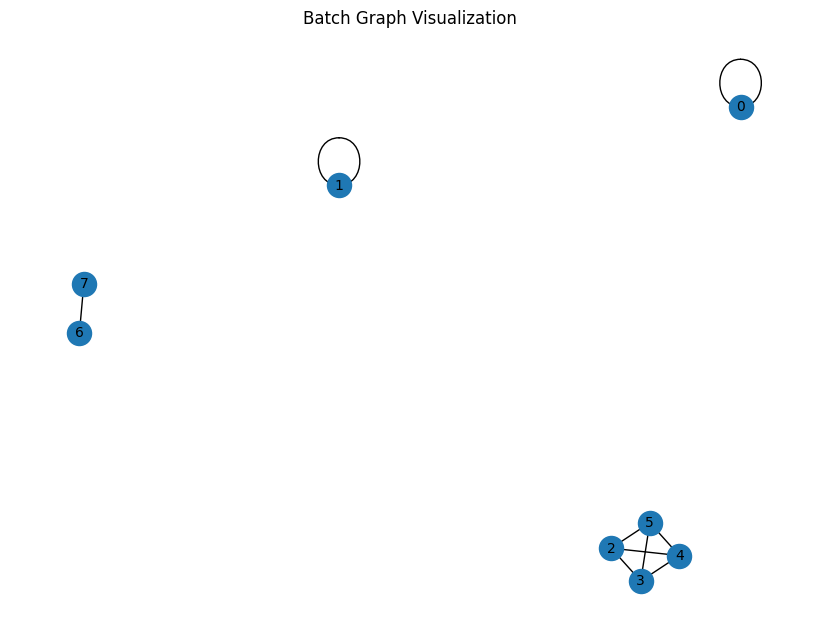

IndexError: Found indices in 'edge_index' that are larger than 3 (got 7). Please ensure that all indices in 'edge_index' point to valid indices in the interval [0, 4) in your node feature matrix and try again.

In [66]:
import torch
import torch_geometric
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt


# Define the device (use CUDA if available, otherwise use CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define atom_types_dim based on your feature encoding
# For example, if you use atomic radius, electronegativity, and dipole moment as features for each atom type
atom_types_dim = 300  # For this case, you would need 3 features per atom type

# Initialize the model
model = MagneticTopologicalTransformer(
    input_dim=atom_types_dim, 
    hidden_dim=128,
    num_heads=4, 
    edge_attr_dim= 3
).to(device)  # Make sure to move the model to the correct device

# Preprocess data with TQC insights
enhanced_data = preprocess_structures_with_tqc(structures_list_mp, bcs_id="3.7")

# Split data
indices = np.arange(len(enhanced_data))
np.random.shuffle(indices)
index_tr, index_va, index_te = np.split(indices, [int(.8 * len(indices)), int(.9 * len(indices))])

# Create dataloaders
batch_size = 4 # Increased batch size for transformer
print(f"Length of enhanced_data: {len(enhanced_data)}")

from torch_geometric.loader import DataLoader
print([type(g) for g in enhanced_data])

# dataloader = DataLoader(
#     [enhanced_data[i] for i in index_tr], 
#     batch_size=batch_size, 
#     shuffle=True
# )
# dataloader_valid = DataLoader(
#     [enhanced_data[i] for i in index_va], 
#     batch_size=batch_size
# )
# Create DataLoader instances using the batched data
dataloader = DataLoader(enhanced_data, batch_size=4, shuffle=True)
dataloader_valid = DataLoader(enhanced_data, batch_size=4)

# Initialize optimizer with learning rate warmup
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)

# Learning rate scheduler (Cosine annealing with warmup)
scheduler = CosineAnnealingWarmRestarts(
    optimizer, 
    T_0=100,  # First restart period
    T_mult=2,  # Multiply restart period after each cycle
    eta_min=0,  # Minimum learning rate
    last_epoch=-1  # Start from epoch 0
)

# Training function placeholder (assuming you have defined it previously)
def train_mag_topo_model(model, optimizer, scheduler, dataloader, dataloader_valid, max_epochs, device):
    model.train()
    for epoch in range(max_epochs):
        for batch in dataloader:
            batch = batch.to(device)
            # Debug info: print shapes and check edge_index validity
            print("Batch x.shape:", batch.x.shape)
            print("Batch edge_index.shape:", batch.edge_index.shape)
            print("Batch edge_index max:", batch.edge_index.max().item())
            print("Batch node assignment shape:", batch.batch.shape)
            # Ensure edge indices are within [0, total_nodes)
            assert batch.edge_index.max().item() < batch.x.shape[0], (
                f"edge_index out of bounds! Max index: {batch.edge_index.max().item()}, "
                f"num_nodes: {batch.x.shape[0]}"
            )
            
            optimizer.zero_grad()
            magnetic_pred, topological_pred = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            loss = compute_loss(magnetic_pred, topological_pred, batch)
            loss.backward()
            optimizer.step()
            scheduler.step()
        
        # Optionally, evaluate on the validation set here.
        print(f"Epoch {epoch+1}/{max_epochs} completed.")
        
# def train_mag_topo_model(model, optimizer, scheduler, dataloader, dataloader_valid, max_epochs, device):
#     model.train()
#     for epoch in range(max_epochs):
#         for batch in dataloader:
            
#             nx_graph = to_networkx(batch, to_undirected=True)
#             plt.figure(figsize=(8, 6))
#             nx.draw(nx_graph, with_labels=True, node_size=300, font_size=10)
#             plt.title("Batch Graph Visualization")
#             plt.show()

#             batch = batch.to(device)  # Ensure the batch is on the correct device
#             optimizer.zero_grad()
#             magnetic_pred, topological_pred = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
#             # Define loss functions and backpropagate here
#             loss = compute_loss(magnetic_pred, topological_pred, batch)
#             loss.backward()
#             optimizer.step()
#         scheduler.step()

#         # Validation
#         model.eval()
#         with torch.no_grad():
#             for batch in dataloader_valid:
             
               
#                 batch = batch.to(device)  # Ensure validation batch is on the correct device
#                 magnetic_pred, topological_pred = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
#                 # Compute validation loss or any evaluation metric here
#                 val_loss = compute_loss(magnetic_pred, topological_pred, batch)
        
#         print(f"Epoch {epoch+1}/{max_epochs}, Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}")


for i, data in enumerate(enhanced_data):
    assert isinstance(data, DataPeriodicNeighbors)
    # print(f"Graph {i}:")
    # print(f"  num_nodes: {data.num_nodes}")
    # print(f"  edge_index max: {data.edge_index.max().item()}")
    # print(f"  edge_index shape: {data.edge_index.shape}")

for i, g in enumerate(enhanced_data):
    print(f"Graph {i}: x.shape = {g.x.shape}, num_nodes = {g.num_nodes}")

for batch in dataloader:
    print("Batched x shape:", batch.x.shape)
    print("Batched edge_index max:", batch.edge_index.max())
    print("Batched num_nodes:", batch.num_nodes)
    break



# Train the model
train_mag_topo_model(
    model, 
    optimizer, 
    scheduler,
    dataloader, 
    dataloader_valid, 
    max_epochs=1, 
    device=device
)



In [ ]:
# # Initialize the model
# atom_types_dim = 3
# model = MagneticTopologicalTransformer(
#     input_dim=atom_types_dim, 
#     hidden_dim=128,
#     num_heads=4
# )

# # Preprocess data with TQC insights
# enhanced_data = preprocess_structures_with_tqc(structures_list_mp, bcs_id="3.7")

# # Split data
# indices = np.arange(len(enhanced_data))
# np.random.shuffle(indices)
# index_tr, index_va, index_te = np.split(indices, [int(.8 * len(indices)), int(.9 * len(indices))])

# # Create dataloaders
# batch_size = 16  # Increased batch size for transformer
# dataloader = torch_geometric.data.DataLoader(
#     [enhanced_data[i] for i in index_tr], 
#     batch_size=batch_size, 
#     shuffle=True
# )
# dataloader_valid = torch_geometric.data.DataLoader(
#     [enhanced_data[i] for i in index_va], 
#     batch_size=batch_size
# )

# # Initialize optimizer with learning rate warmup
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
# scheduler = get_cosine_schedule_with_warmup(
#     optimizer, 
#     num_warmup_steps=100, 
#     num_training_steps=100*len(dataloader)
# )

# # Train model
# train_mag_topo_model(
#     model, 
#     optimizer, 
#     scheduler,
#     dataloader, 
#     dataloader_valid, 
#     max_epochs=100, 
#     device= 'cpu'
# )